In [1]:
#NN Surrogate model class
import injector_surrogate_quads
from injector_surrogate_quads import *
import physics_gp
import os

sys.path.append('../configs')
#Sim reference point to optimize around
from ref_config import ref_point

#Pytorch 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gpytorch
import botorch 

import matplotlib.pyplot as plt

random_seed = 1
torch.manual_seed(random_seed)

In [2]:
# load injector model
Model = Surrogate_NN()

Model.load_saved_model(model_path = '../models/', \
                       model_name = 'model_OTR2_NA_rms_emit_elu_2021-07-27T19_54_57-07_00')
Model.load_scaling()
Model.take_log_out = False

2022-06-28 14:10:17.353823: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# design Twiss parameters 
beamline_info = json.load(open('../configs/beamline_info.json'))
get_twiss0 = beamline_info['Twiss0']

# emit, beta, alpha
twiss0 = {'x': [get_twiss0[0], get_twiss0[2], get_twiss0[4]],
          'y': [get_twiss0[1], get_twiss0[3], get_twiss0[5]]}

beta0_x, alpha0_x = twiss0['x'][1], twiss0['x'][2]
beta0_y, alpha0_y = twiss0['y'][1], twiss0['y'][2]
# print(twiss0['x'])
# print(twiss0['y'])

## Objective Function

In [4]:
# convert to machine units
ref_point = Model.sim_to_machine(np.asarray(ref_point))

# input params: solenoid and quads to vary 
opt_var_names = ['SOL1:solenoid_field_scale','CQ01:b1_gradient', 'SQ01:b1_gradient',
                 "QA01:b1_gradient", "QA02:b1_gradient", 
                 "QE01:b1_gradient", "QE02:b1_gradient", "QE03:b1_gradient", "QE04:b1_gradient"]
bounds = torch.as_tensor([[0.46, 0.485], [-0.02, 0.02], [-0.02, 0.02],
                       [-4, -1], [1, 4],
                       [-7,-1], [-1, 7],[-1, 7], [-7, 1]])

# output params: emittance in transverse plane (x & y)
opt_out_names = ['norm_emit_x','norm_emit_y']

def evaluate(config): 
    """
    D is input space dimensionality
    :param config: input values of opt_var_names, torch.tensor, shape (1, D) 
    """
    #make input array of length model_in_list (inputs model takes)
    x_in = np.empty((1,len(Model.model_in_list)))

    #fill in reference point around which to optimize
    x_in[:,:] = np.asarray(ref_point[0])

    #set solenoid, CQ, SQ, matching quads to values from optimization step
    for i in range(config.size(dim=0)):
        x_in[:, Model.loc_in[opt_var_names[i]]] = config[i]

    #output predictions
    y_out = Model.pred_machine_units(x_in) 

    return -1*objective(y_out)[0]


def objective(y_out):
    # output is emittance * bmag 
    
    # geometric emittance in transverse plane
    out1 = y_out[:, Model.loc_out['norm_emit_x']] #grab norm_emit_x out of the model
    out2 = y_out[:, Model.loc_out['norm_emit_y']] #grab norm_emit_y out of the model
    emit = np.sqrt(out1 * out2)
  
    sigma_x = y_out[:, Model.loc_out['sigma_x']] #grab sigma_x out of the model 
    sigma_y = y_out[:, Model.loc_out['sigma_y']] #grab sigma_y out of the model 
    
    # real beta and alpha 
    # NEEDS TO BE FIXED - currently assuming real alpha to be the same as design alpha 
    alpha_x, alpha_y = alpha0_x, alpha0_y
    beta_x, beta_y = (sigma_x**2) / out1, (sigma_y**2) / out2
    
    # bmag 
    bmag_x = 0.5 * ((beta0_x / beta_x) + (beta_x / beta0_x)) + 0.5 * ((alpha_x * np.sqrt(beta0_x / beta_x) - alpha0_x * np.sqrt(beta_x / beta0_x))**2)
    bmag_y = 0.5 * ((beta0_y / beta_y) + (beta_y / beta0_y)) + 0.5 * ((alpha_y * np.sqrt(beta0_y / beta_y) - alpha0_y * np.sqrt(beta_y / beta0_y))**2)
    bmag = np.sqrt(bmag_x * bmag_y)
    #print(f'bmag: {bmag} emit: {emit}') 
    
    return (emit * bmag)/1e-6 # in um units 
    #return np.sqrt(out1*out2)/1e-6 # in um units

torch.Size([19219, 9]) torch.Size([19219, 1])


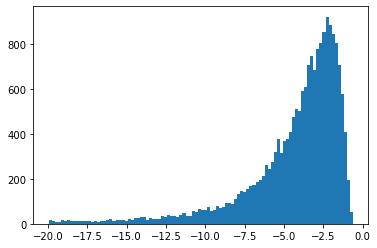

In [11]:
# mesh grid of 3^9 points to sample
n_samples_per_var = 3
n_var = 9

"""
create x and y if they are not saved in grid.pt, otherwise load x and y from grid.pt
"""
# create input and output data
if os.path.exists('./results/grid.pt') and os.stat('./results/grid.pt').st_size > 0: 
    training_dict = torch.load('grid.pt')
    x = training_dict['x']
    y = training_dict['y']
else: 
    var_points = torch.zeros((n_var, n_samples_per_var)) 
    # take n_samples_per_var points from each dimension i
    for i in range(n_var):
        var_points[i,:] = torch.linspace(bounds[i,0],bounds[i,1],n_samples_per_var)

    # generate grid of points to sample 
    grid = np.array(np.meshgrid(*var_points)).reshape(n_var,-1)
    x = torch.zeros((n_samples_per_var**n_var, n_var))
    for i in range(n_samples_per_var**n_var):
        x[i:] = torch.as_tensor(grid[:,i])
    y = torch.as_tensor([evaluate(ele) for ele in x])
    torch.save({'x': x, 'y': y}, 'grid.pt')

y = y.reshape(-1,1)

x = x[torch.where(y > -20)[0]]
y = y[torch.where(y > -20)[0]]
print(x.shape, y.shape)

plt.hist(y.numpy(), bins = 100);

## Fit data with a Neural Network

In [12]:
# create training and validation datasets 
batch_size = 1024

transformer_x = botorch.models.transforms.input.Normalize(n_var, bounds = bounds.transpose(0,1))
normed_x = transformer_x(x)
transformer_x.eval()

transformer_y = botorch.models.transforms.input.Normalize(1)
transformer_y.train()
normed_y = transformer_y(y)
transformer_y.eval()
print(torch.min(y), torch.max(y))

data = torch.utils.data.TensorDataset(normed_x.float(), normed_y.float())

##### if validating, create validation and training data sets #####
# train_size = int(0.8 * len(data))
# valid_size = len(data) - train_size
# train_data, valid_data = torch.utils.data.random_split(data, [train_size, valid_size])
# print(len(train_data), len(valid_data))

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
#valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data)
print(example_targets)

tensor(-19.9555, dtype=torch.float64) tensor(-0.6188, dtype=torch.float64)
tensor([[0.0000, 0.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
        [0.5000, 0.5000, 0.0000,  ..., 0.5000, 1.0000, 0.5000],
        [0.0000, 0.0000, 0.5000,  ..., 1.0000, 0.5000, 0.5000],
        ...,
        [1.0000, 1.0000, 0.5000,  ..., 0.5000, 0.5000, 1.0000],
        [1.0000, 0.0000, 0.5000,  ..., 0.5000, 0.5000, 1.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[0.8372],
        [0.8223],
        [0.9191],
        ...,
        [0.8815],
        [0.8392],
        [0.8612]])


In [6]:
# model 
class NN_prior(nn.Module):
    def __init__(self):
        super(NN_prior, self).__init__()
        
        hidden_size = 20
        self.network = nn.Sequential(nn.Linear(n_var, hidden_size), 
                                     nn.Tanh(), 
                                     nn.Linear(hidden_size, hidden_size), 
                                     nn.Tanh(),
                                     nn.Linear(hidden_size, 1))
        
    def forward(self, x):
        x = self.network(x)
        return x 

In [19]:
log_interval = 20
def train_model(model, epochs, train_loader, valid_loader, optimizer):
    """
    trains the NN model and tests the model on validation dataset every epoch
    returns training and validation losses as arrays
    """
    train_losses = []
    valid_losses = []
    best_valid = 1e8
    
    for epoch in range(epochs):
        ######### train #########
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad() 
            output = model(data) 
            
            loss = F.mse_loss(output, target) 
            loss.backward()
            
            optimizer.step() 
            
            if epoch % log_interval == 0 and batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            
        ######### validate #########    
#         model.eval()
#         valid_loss = 0.0
#         for batch_idx, (data, target) in enumerate(valid_loader):
#             output = model(data) 
#             valid_loss += (output - target).pow(2).sum()
        
#         valid_loss = valid_loss / valid_size
#         valid_losses.append(valid_loss.detach()) 
        
#         #save model if highest validation score 
#         if (valid_loss < best_valid):
#             print("Saved model!")
#             best_valid = valid_loss       

        torch.save(model.state_dict(), './results/model1.pth') 
        torch.save(optimizer.state_dict(), './results/optimizer.pth')
            
    return train_losses, valid_losses


In [20]:
NN_prior_model = NN_prior()
NN_optimizer = optim.Adam(NN_prior_model.parameters(), lr = 0.01)
n_epochs = 750
train_losses, valid_losses = train_model(NN_prior_model, n_epochs, train_loader, None, NN_optimizer)

Train Epoch: 0 [0/19219 (0%)]	Loss: 0.517176
Train Epoch: 20 [0/19219 (0%)]	Loss: 0.025160
Train Epoch: 40 [0/19219 (0%)]	Loss: 0.018573
Train Epoch: 60 [0/19219 (0%)]	Loss: 0.021880
Train Epoch: 80 [0/19219 (0%)]	Loss: 0.020661
Train Epoch: 100 [0/19219 (0%)]	Loss: 0.018348
Train Epoch: 120 [0/19219 (0%)]	Loss: 0.017478
Train Epoch: 140 [0/19219 (0%)]	Loss: 0.013346
Train Epoch: 160 [0/19219 (0%)]	Loss: 0.011663
Train Epoch: 180 [0/19219 (0%)]	Loss: 0.012939
Train Epoch: 200 [0/19219 (0%)]	Loss: 0.010112
Train Epoch: 220 [0/19219 (0%)]	Loss: 0.009758
Train Epoch: 240 [0/19219 (0%)]	Loss: 0.009790
Train Epoch: 260 [0/19219 (0%)]	Loss: 0.010701
Train Epoch: 280 [0/19219 (0%)]	Loss: 0.009701
Train Epoch: 300 [0/19219 (0%)]	Loss: 0.008888
Train Epoch: 320 [0/19219 (0%)]	Loss: 0.008946
Train Epoch: 340 [0/19219 (0%)]	Loss: 0.007713
Train Epoch: 360 [0/19219 (0%)]	Loss: 0.007641
Train Epoch: 380 [0/19219 (0%)]	Loss: 0.008158
Train Epoch: 400 [0/19219 (0%)]	Loss: 0.007073
Train Epoch: 420 [0

## Scan

In [13]:
# models  
training_dict = torch.load('grid.pt')
x = training_dict['x']
y = training_dict['y']
A = training_dict['A']
B = training_dict['B'] 
C = training_dict['C'] 
y_pred = training_dict['y_pred']

def polynomial_model(x):
    """
    :param x: input values, tensor, shape (num_samples, num_var) 
    returns y_pred as tensor, shape (1, num_samples) 
    """ 
    return torch.cat([torch.matmul(ele, torch.matmul(A, ele.T)) + torch.matmul(B, ele.T) + C for ele in x.float()]).reshape(1,-1)[0]

NN_model = NN_prior()
NN_model.load_state_dict(torch.load('./results/model_1hidden_20nodes_500epoch_0.02.pth'))
NN_model.eval()

print(transformer_y.untransform(NN_model(normed_x[0])))
#best = NN_y_100epochs_4hidden_tanh

tensor([[-8.3896]], dtype=torch.float64, grad_fn=<AddBackward0>)


tensor([ 4.7797e-01, -1.4992e-03, -6.8730e-04, -2.0006e+00,  2.0006e+00,
        -2.0218e-01, -1.7939e-01,  2.8522e+00, -3.2184e+00],
       dtype=torch.float64)


2022-06-28 14:11:29.076021: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-28 14:11:29.084726: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1996335000 Hz


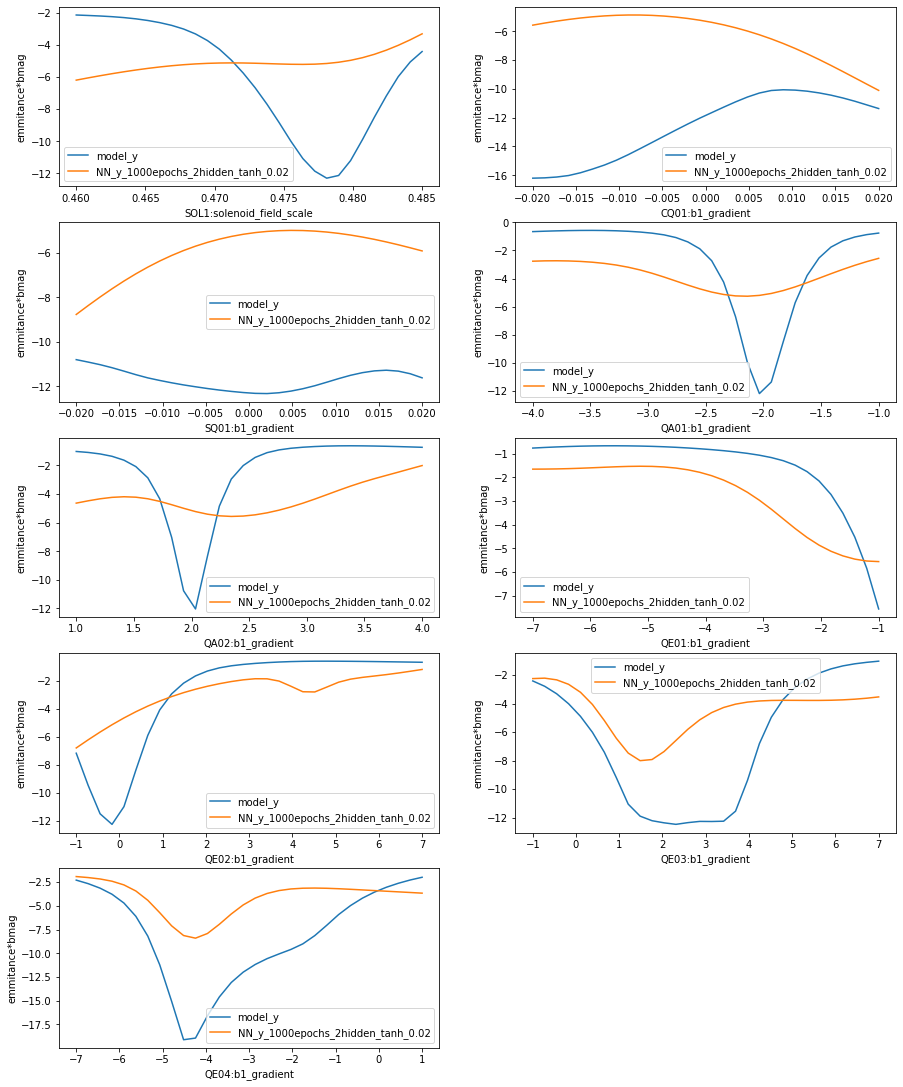

In [15]:
# use ref point values for the parameters that are kept constant 
scan_ref_point = torch.cat([torch.as_tensor([ref_point[0][Model.loc_in[param_name]]]) for param_name in opt_var_names])
print(scan_ref_point)

plt.rcParams["figure.figsize"] = (15,5)
# plot loss
#plt.plot(valid_losses, label = "train")
# plt.semilogy(valid_losses, label = "log_valid")
# plt.legend()
# plt.show()
 
def scan(model_param, num_scans, model_prior):
    """
    scans values across a single parameter of the model, keeping others constant
    :param model_param: name of the model param that is being scanned, string, size 1 
    :param num_scans: number of values scanned for parameter 
    returns model_test_y, polynomial_test_y of all scanned values  
    """ 
    param_index = opt_var_names.index(model_param)
    test_x = scan_ref_point.repeat(num_scans, 1) 
    test_x[:,param_index] = torch.linspace(bounds[param_index, 0], bounds[param_index, 1], num_scans)
    #print(test_x)
    
    model_test_y = torch.as_tensor([evaluate(ele) for ele in test_x])
    normed_prior_test_y = model_prior(transformer_x(test_x).float()) 
    prior_test_y = transformer_y.untransform(normed_prior_test_y)
    #prior_test_y = model_prior(F.normalize(test_x, dim = 0).float()) 
    return model_test_y, prior_test_y, test_x

plt.gcf().set_size_inches(15,35)
for i in range(len(opt_var_names)):
    model_param = opt_var_names[i] 
    model_test_y, prior_test_y, test_x = scan(model_param, 30, NN_model) 
    plt.subplot(9, 2, i+1)
    plt.xlabel(model_param)
    plt.ylabel('emmitance*bmag')
    plt.plot(test_x[:,opt_var_names.index(model_param)], model_test_y, label = "model_y")
    plt.plot(test_x[:,opt_var_names.index(model_param)], prior_test_y.detach(), label = "NN_y_1000epochs_2hidden_tanh_0.02")
    plt.legend()
    
plt.show()
